In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pycountry
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import preprocess as pre

In [6]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

/Users/milesli/Desktop/Age-Based-Personalised-Books-Recommendation-System/Report&Coding/data&code/preprocess.py:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Book-Author"].fillna("NO AUTHOR", inplace=True)


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,50196,bradenton,florida,united states,5.0,0-10,0061031011,6,have a nice day!: a tale of blood and sweatsocks,mick foley,2000,reganbooks,medium
1,50196,bradenton,florida,united states,5.0,0-10,0679435271,8,a pirate looks at fifty,jimmy buffett,1998,random house trade,high
2,50196,bradenton,florida,united states,5.0,0-10,0786889756,9,red light,t. jefferson parker,2001,hyperion,high
3,85501,columbia,missouri,united states,5.0,0-10,0316096199,8,lucky : a memoir,alice sebold,2002,back bay books,high
4,97531,pickens,south carolina,united states,5.0,0-10,0449212602,8,the handmaid's tale,margaret atwood,1989,fawcett books,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,114865,croydon,victoria,australia,97.0,90-100,0553271067,10,passages: predictable crises of adult life,gail sheehy,1984,bantam,high
204160,114865,croydon,victoria,australia,97.0,90-100,0749309423,9,the silence of the lambs,thomas harris,1991,mandarin,high
204161,228990,private,michigan,united states,99.0,90-100,0425122123,7,clear and present danger (jack ryan novels),tom clancy,1996,berkley publishing group,high
204162,228990,private,michigan,united states,99.0,90-100,044022165X,8,the rainmaker,john grisham,1996,dell,high


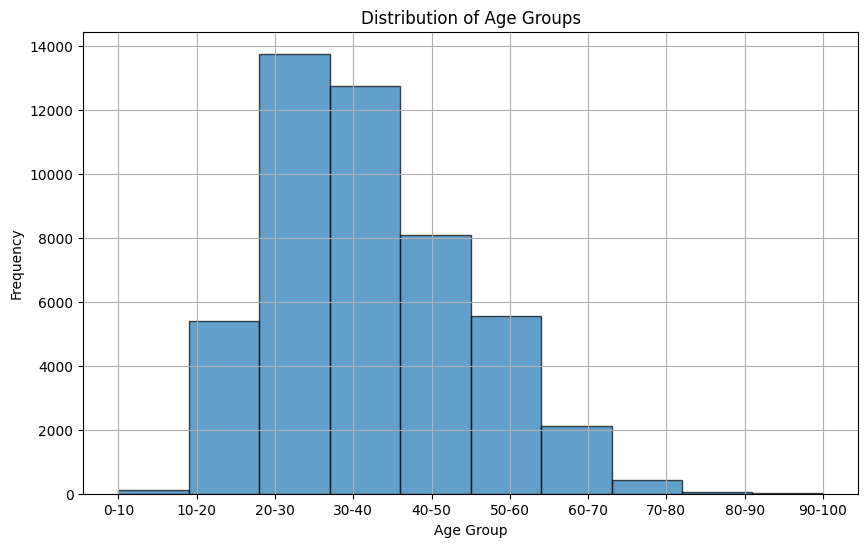

In [7]:
users_df = pd.read_csv(users_file)
ratings_df = pd.read_csv(rating_file)
books_df = pd.read_csv(books_file)

# Imputation missing data and discretise the age based on an age group
users_df = pre.ages_imputation(pre.weighted_age_dict(users_file), users_df)
users_df = pre.city_imputation(users_df)
users_df = pre.state_imputation(users_df)
users_df = pre.country_imputation(users_df)
merged_df = pre.discretising(users_df, ratings_df, books_df)
merged_df = pre.author_imputation(merged_df)
merged_df = pre.text_process(merged_df)
merged_df.to_csv("merge.csv", index=False)

merged_df

Get books names and book ratings

In [4]:
books_rating_df = merged_df[["ISBN", "Book-Title", "Book-Rating"]]
average_ratings = (books_rating_df.groupby(["ISBN", "Book-Title"])["Book-Rating"].mean().reset_index())
books_rating_df = average_ratings.drop_duplicates(subset=["Book-Title"])
rate_bins = [0, 4, 7, 11]
rate_labels = ["low", "medium", "high"]
books_rating_df["Rating_Category"] = pd.cut(
        books_rating_df["Book-Rating"], bins=rate_bins, labels=rate_labels, right=False
    )
books_rating_df

/var/folders/2t/py1z_kfj5dxf0cz542svdzwr0000gn/T/ipykernel_10365/4190279325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_rating_df["Rating_Category"] = pd.cut(


,ISBN,Book-Title,Book-Rating,Rating_Category
0,0002005018,clara callan,7.500000,high
1,0002116286,there's a seal in my sleeping bag,7.250000,high
2,0002243962,girlfriend in a coma,5.750000,medium
3,0002251760,the forgetting room: a fiction (byzantium book),8.833333,high
4,0002255081,spadework,6.250000,medium
...,...,...,...,...
18180,9722105248,o evangelho segundo jesus cristo: romance,8.400000,high
18181,9726101794,as mulheres deviam vir com livro de instruãâ§...,6.000000,medium
18182,9728423160,nos teus braãâ§os morrerãâ­amos: ficãâ§ãâ£o,7.000000,high
18183,9812327975,notes from an even smaller island,8.000000,high


# For Test Set

/Users/milesli/Desktop/Age-Based-Personalised-Books-Recommendation-System/Report&Coding/data&code/preprocess.py:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Book-Author"].fillna("NO AUTHOR", inplace=True)


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,251843,homer city,pennsylvania,united states,5.0,0-10,0060929227,10,shelter for the spirit: create your own haven ...,victoria moran,1998,perennial,high
1,251843,homer city,pennsylvania,united states,5.0,0-10,0060931078,10,the wilder sisters,jo-ann mapson,2000,perennial,high
2,251843,homer city,pennsylvania,united states,5.0,0-10,0312989377,6,summer in tuscany,elizabeth adler,2003,st. martin's paperbacks,medium
3,251843,homer city,pennsylvania,united states,5.0,0-10,0345440099,10,"the shifting tide (perry, anne)",anne perry,2004,ballantine books,high
4,251843,homer city,pennsylvania,united states,5.0,0-10,0394524063,10,the mists of avalon,marion zimmer bradley,1982,random house inc,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,38725,vancouver,british columbia,canada,85.0,80-90,0449223450,8,recessional,james a. michener,1995,fawcett books,high
23141,104404,bonita springs,florida,united states,85.0,80-90,0425197395,6,the mediterranean caper,clive cussler,2004,berkley publishing group,medium
23142,225867,despair,indiana,united states,93.0,90-100,0393322432,5,people who knock on the door,patricia highsmith,2001,w.w. norton & company,medium
23143,114865,croydon,victoria,australia,97.0,90-100,0586037950,9,the golden notebook,doris may lessing,1979,granada publishing,high


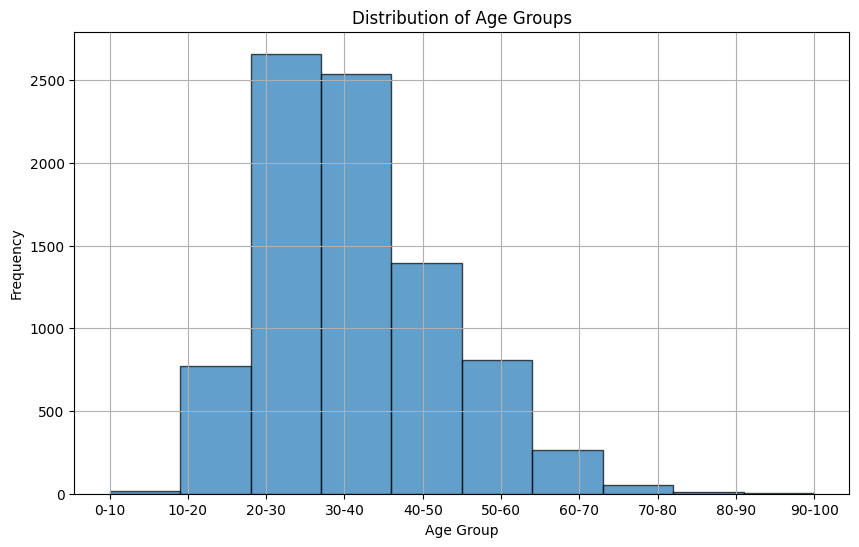

In [8]:
new_users_df = pd.read_csv(new_users_file)
new_ratings_df = pd.read_csv(new_ratings_file)
new_books_df = pd.read_csv(new_books_file)

# Imputation missing data and discretise the age based on an age group
new_users_df = pre.ages_imputation(pre.weighted_age_dict(new_users_file), new_users_df)
new_users_df = pre.city_imputation(new_users_df)
new_users_df = pre.state_imputation(new_users_df)
new_users_df = pre.country_imputation(new_users_df)
test_merged_df = pre.discretising(new_users_df, new_ratings_df, new_books_df)
test_merged_df = pre.author_imputation(test_merged_df)
test_merged_df = pre.text_process(test_merged_df)
test_merged_df

In [6]:
for feature in [
    "User-City",
    "User-State",
    "User-Country",
    "Age-Group",
    "Book-Author",
    "Year-Of-Publication",
    "Book-Publisher",
    "Book-Title"
]:
    print(
        feature,
        pre.compute_information_gain(
            merged_df[feature], merged_df["Rating_Category"]
        ).round(4),
    )

User-City 0.1038
User-State 0.0166
User-Country 0.0022
Age-Group 0.0005
Book-Author 0.0751
Year-Of-Publication 0.0027
Book-Publisher 0.0231
Book-Title 0.1435


In [7]:
# Deleted Features with low IG to train the DT
new_features = [
    "User-City",
    "Book-Author",
    "Book-Title",
]

train_X = OrdinalEncoder().fit_transform(merged_df[new_features])
train_y = OrdinalEncoder().fit_transform(merged_df[["Rating_Category"]])

test_X = OrdinalEncoder().fit_transform(test_merged_df[new_features])
test_y = OrdinalEncoder().fit_transform(test_merged_df[["Rating_Category"]])

# Initialise the DT
dt_classifier = DecisionTreeClassifier(criterion="entropy")

# Train the model
dt_classifier.fit(train_X, train_y)

# Do Cross validation to test the training process
cross_validation = cross_val_score(dt_classifier, train_X, train_y, cv=10)
print("Cross Validation Scores:", cross_validation)
print("Average Score:", np.mean(cross_validation))

pred_y = dt_classifier.predict(test_X)

accuracy = accuracy_score(pred_y, test_y)
print("Final Accuracy:", accuracy)

Cross Validation Scores: [0.66596464 0.63329578 0.63662634 0.62937748 0.61246082 0.63773511
 0.64914773 0.63342476 0.64704154 0.64851097]
Average Score: 0.6393585165348717
Final Accuracy: 0.6227694966515446


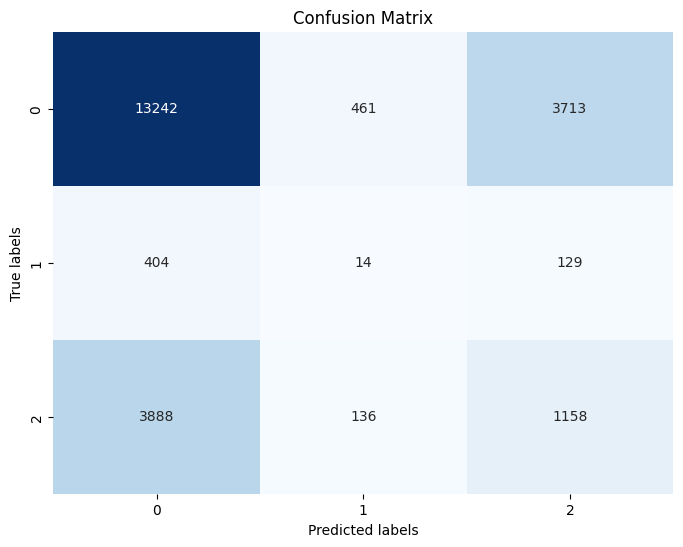

In [8]:
# Confusion matrix
cm = confusion_matrix(test_y, pred_y)

# Visulisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

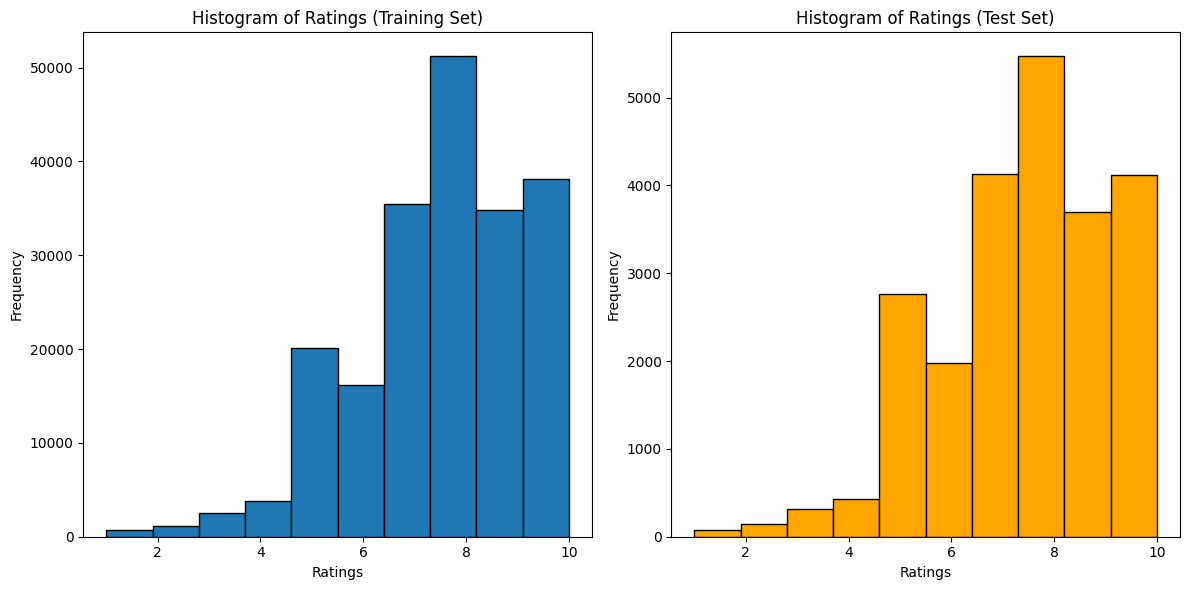

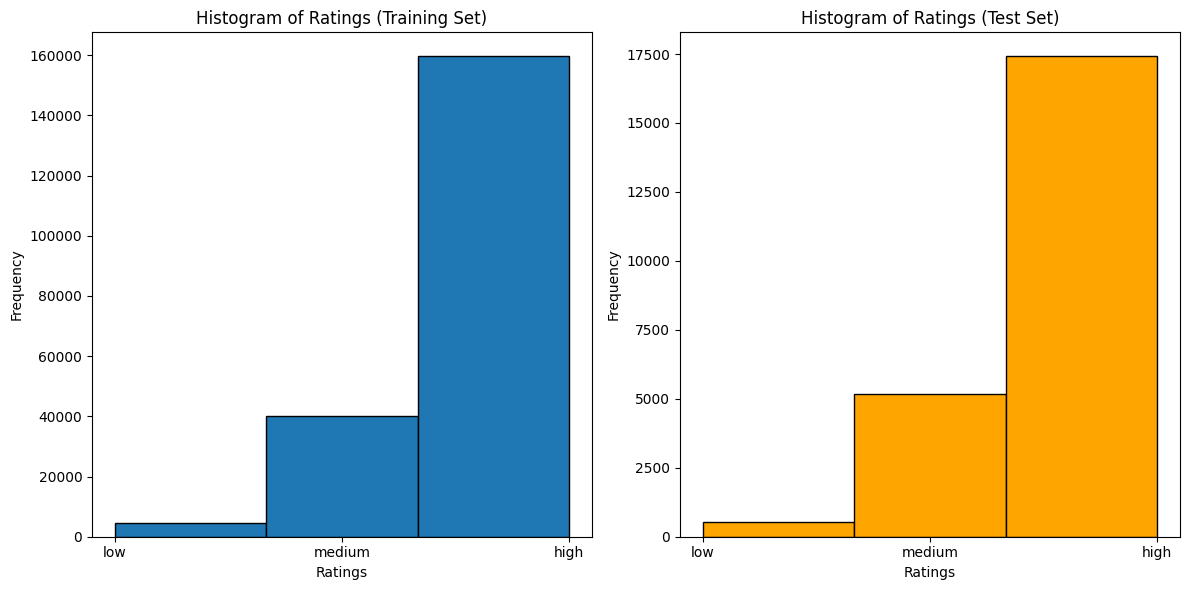

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# For Rating
axs[0].hist(merged_df["Book-Rating"], bins=10, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Book-Rating"], bins=10, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

# For Rating category
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Sort the DataFrame in order of ['low', 'medium', 'high']
merged_df["Rating_Category"] = pd.Categorical(
    merged_df["Rating_Category"], 
    categories=["low", "medium", "high"], 
    ordered=True
)
test_merged_df["Rating_Category"] = pd.Categorical(
    test_merged_df["Rating_Category"],
    categories=["low", "medium", "high"],
    ordered=True,
)

merged_df = merged_df.sort_values(by="Rating_Category")
test_merged_df = test_merged_df.sort_values(by="Rating_Category")

axs[0].hist(merged_df["Rating_Category"], bins=3, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Rating_Category"], bins=3, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")


plt.tight_layout()

## BOW vectors for books' name

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

book_names = set(merged_df["Book-Title"])

# Preprocessing and tokenization
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and duplicates
    tokens = set([word for word in tokens if word not in stopwords.words('english')])
    return " ".join(tokens)

# Preprocess book names
preprocessed_books = [preprocess_text(book) for book in book_names]

# Creating bag-of-words vectors
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(preprocessed_books)

[nltk_data] Downloading package punkt to /Users/milesli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milesli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


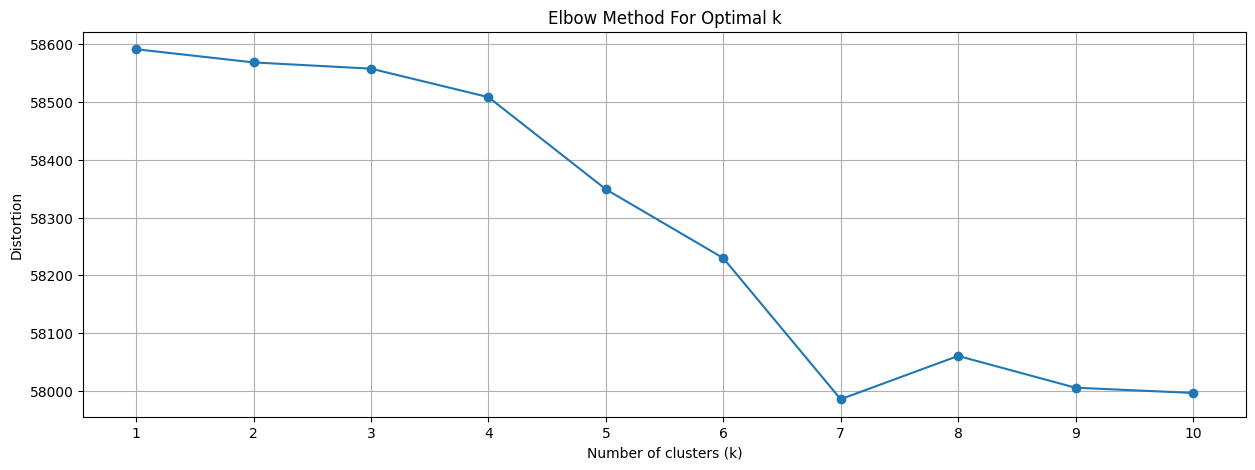

In [11]:
# Calculate distortion for a range of number of cluster
distortions = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bow_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(15, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [12]:
# Perform K-means clustering
num_clusters = 42  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(bow_matrix)

# Get cluster labels and assign each book to a cluster
cluster_labels = kmeans.labels_
book_clusters = {}
for i, book in enumerate(book_names):
    cluster = cluster_labels[i]
    if cluster not in book_clusters:
        book_clusters[cluster] = []
    book_clusters[cluster].append(book)

cluster_no_order = []
# Print out the clusters
for cluster, books in book_clusters.items():
    cluster_no_order.append(cluster + 1)
    print(f"Cluster {cluster + 1}:")
    print(len(books))
    '''for book in books:
        print(f"- {book}")'''

# If you are a user, you can input the book's name which you like, 
# it will output a cluster of books which are similar to what you like
def recomend_book_cluster(book_name):
    book_name = str(book_name).lower()
    for cluster_num, books in book_clusters.items():
        if book_name in books:
            return cluster_num
    return -1

# Extract highly rated books
highly_rated_book_clusters = {}

for cluster, books in book_clusters.items():
    highly_rated_books = []
    for book in books:
        book_info = books_rating_df[
            (books_rating_df["Book-Title"] == book)
            & (books_rating_df["Rating_Category"] == "high")
        ]
        if not book_info.empty:
            highly_rated_books.append(book)
    if highly_rated_books:
        highly_rated_book_clusters[cluster] = highly_rated_books

# Print the results
for cluster, books in highly_rated_book_clusters.items():
    print(f"Cluster {cluster + 1} (Highly Rated Books):", len(books))
    print(books)

Cluster 2:
12630
Cluster 31:
7
Cluster 23:
82
Cluster 10:
637
Cluster 18:
59
Cluster 38:
51
Cluster 37:
131
Cluster 20:
11
Cluster 22:
77
Cluster 32:
342
Cluster 42:
94
Cluster 35:
107
Cluster 16:
48
Cluster 5:
162
Cluster 11:
50
Cluster 9:
372
Cluster 3:
23
Cluster 27:
254
Cluster 40:
75
Cluster 7:
46
Cluster 17:
54
Cluster 19:
48
Cluster 13:
132
Cluster 8:
46
Cluster 28:
100
Cluster 21:
53
Cluster 24:
32
Cluster 26:
25
Cluster 41:
79
Cluster 25:
17
Cluster 33:
3
Cluster 30:
14
Cluster 34:
19
Cluster 14:
43
Cluster 29:
24
Cluster 15:
9
Cluster 39:
6
Cluster 6:
1
Cluster 4:
3
Cluster 1:
7
Cluster 12:
2
Cluster 36:
1
Cluster 2 (Highly Rated Books): 10132
['summer island', 'fifth business', 'red azalea', 'doing good', 'south of the border, west of the sun', "dropped threads 2: more of what we aren't told", 'cutwork', 'the unexpected mrs. pollifax', "jarhead : a marine's chronicle of the gulf war and other battles", 'hot chocolate for the mystical soul: 101 true stories of angels, miracle

In [13]:
from sklearn.metrics import pairwise_distances

# Compute centroids of clusters
cluster_centroids = kmeans.cluster_centers_

# Compute pairwise distances between centroids
distances = pairwise_distances(cluster_centroids)

# Print out distances between clusters
print("Distances between clusters:")
for i in range(num_clusters):
    cluster = cluster_no_order[i]
    for j in range(i+1, num_clusters):
        other_cluster = cluster_no_order[j]
        print(f"Cluster {cluster} to Cluster {other_cluster}: {distances[i][j]}")


Distances between clusters:
Cluster 2 to Cluster 31: 1.8084936816272816
Cluster 2 to Cluster 23: 2.1608926851806878
Cluster 2 to Cluster 10: 3.0654241789392533
Cluster 2 to Cluster 18: 1.9581860948397234
Cluster 2 to Cluster 38: 3.2071349029490923
Cluster 2 to Cluster 37: 2.6123421718849107
Cluster 2 to Cluster 20: 2.1117829739801737
Cluster 2 to Cluster 22: 2.066059650852645
Cluster 2 to Cluster 32: 2.0765979257816207
Cluster 2 to Cluster 42: 2.104878686697712
Cluster 2 to Cluster 35: 4.305312333119896
Cluster 2 to Cluster 16: 2.100497963860618
Cluster 2 to Cluster 5: 2.0898277562978285
Cluster 2 to Cluster 11: 2.854805040029613
Cluster 2 to Cluster 9: 2.074893619380528
Cluster 2 to Cluster 3: 2.084969962672819
Cluster 2 to Cluster 27: 1.9629995565454987
Cluster 2 to Cluster 40: 1.9553707327207677
Cluster 2 to Cluster 7: 2.512072386326485
Cluster 2 to Cluster 17: 2.446550119278468
Cluster 2 to Cluster 19: 2.4960755164136637
Cluster 2 to Cluster 13: 2.5046442796575548
Cluster 2 to Clus

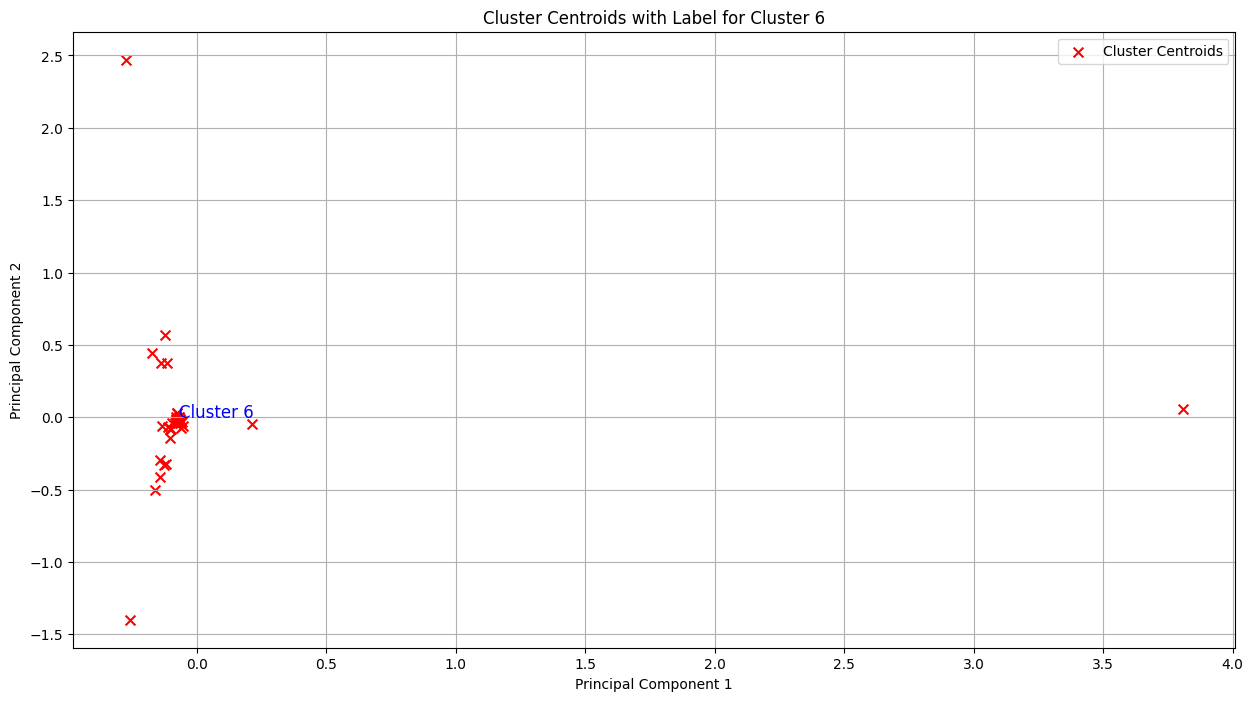

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality of centroids using PCA
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(cluster_centroids)

# Plot the centroids
plt.figure(figsize=(15, 8))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='x', color='red', label='Cluster Centroids', s=50)

# Annotate the centroid corresponding to cluster 6
cluster_6_index = cluster_no_order.index(6)  # Index of cluster 6 in the centroids array
plt.annotate('Cluster 6', (centroids_2d[cluster_6_index, 0], centroids_2d[cluster_6_index, 1]), fontsize=12, color='blue')

plt.title('Cluster Centroids with Label for Cluster 6')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
